# Global motif association analysis

Here we apply statistical methods to associate differiatial motif matches between the two alleles to the differential signal. We implement three methods: A) We compute the correlation between motif score differences with allelic ratios for all sequences in which the motif was present in at least one allele. B) Following the MeanDiff strategy proposed in[(van der Veeken et al. 2020)](#1) we compare the signal differences between regions that have a positive motif difference in B6 with positive motif difference in CAST, C) Following the strategy from [(Shen et al. 2020)](#2), we determine sequences that show significant differences between allelic signals and test if the distribution of delta motif scores differ from zero.   

The notebook returns sets of sequences that are affected by the signal, sequences that contain a transcription factor motif match, sequences that contain a disrupted TF motif, associated sequences for each TF. The results are presented as global p-values for all tested motifs, in a tree with the associated motifs, and a pie-chart that shows how many sequences are associated with each motif.

<a id="1">[1]</a> van der Veeken J, Glasner A, Zhong Y, Hu W, Wang ZM, Bou-Puerto R, Charbonnier LM, Chatila TA, Leslie CS, Rudensky AY. The Transcription Factor Foxp3 Shapes Regulatory T Cell Identity by Tuning the Activity of trans-Acting Intermediaries. Immunity. 2020 Nov 17;53(5):971-984.e5. [doi: 10.1016/j.immuni.2020.10.010](doi:10.1016/j.immuni.2020.10.010). Epub 2020 Nov 10. PMID: 33176163; PMCID: PMC8363055. 

<a id="2">[2]</a> Shen Z, Hoeksema MA, Ouyang Z, Benner C, Glass CK. MAGGIE: leveraging genetic variation to identify DNA sequence motifs mediating transcription factor binding and function. Bioinformatics. 2020 Jul 1;36(Suppl_1):i84-i92. [doi: 10.1093/bioinformatics/btaa476](doi:10.1093/bioinformatics/btaa476). PMID: 32657363; PMCID: PMC7355228. 

### Content overview

1. Load signal and determine regions with allelic imbalance
2. Load sequences and determine regions with motif matches in at least one of the two alleles with FIMO
3. Align sequences and determine differential motif scores
4. Associate differential motif scores with differential signal with one of the three suggested methods
5. Plot results for associated motifs and their associated sequences

## 1. Load signal and determine regions regions with allelic imbalance

In [1]:
import numpy as np
import os

# Set the path to the directory containing the data files
#path = '/home/sasse/Git/DeepAllele-public/data/atac/results/mh/sum/'
path = '/home/sasse/Git/DeepAllele-public/data/chip/results/mh/PWK'
data_name = 'PWK'
seqlabels = os.path.join(path, f'{data_name}_val_seq_labels.npy')
signals = os.path.join(path, f'{data_name}_val_obs.npy')

# Load the numpy arrays from the specified files
seqlabels = np.load(seqlabels, allow_pickle=True)
signals = np.load(signals, allow_pickle=True)
print('seqlabels shape:', seqlabels.shape)
print('signals shape:', signals.shape)

# Determine significant indices based on log-fold allelic ratio
# NOTE: If multiple replicates are given, one should perform a statistical test to determine which allelic ratio is significant.
ratio_cut = 1. 
affected = np.where(np.abs(signals[:, 2]) >= ratio_cut)[0]
print('affected:', len(affected), 'out of', signals.shape[0], 'samples')

direction_affected = np.sign(signals[affected, 2])
# Get the affected sequence labels
affected_seqlabels = seqlabels[affected]
# Get the affected signals
affected_signals = signals[affected]


seqlabels shape: (8380,)
signals shape: (8380, 3)
affected: 1016 out of 8380 samples


## 2. Load sequences and determine regions with motif matches in at least one of the two alleles with FIMO


In [2]:
import numpy as np
import os
from tangermeme.tools.fimo import fimo
from tangermeme.io import read_meme

# Load the motifs from a file
motif_file = '/home/sasse/Git/DeepAllele-public/motifdatabase/JASPAR2020_CORE_vertebrates_non-redundant_pfms.TFnames.meme'
motifs = read_meme(motif_file)

# Load the sequences to search for motifs
seq_file = os.path.join(path, f'{data_name}_val_seqs.npy')



In [74]:
import numpy as np
import time 

X = np.load(seq_file, allow_pickle=True)
print('X shape:', X.shape) # Run fimo over all sequences to get global hits and also global motif changes, where not change in signal occured

# correct format for FIMO
XA = np.transpose(X[..., 0], (0, 2, 1))  # Transpose to have channels first
XB = np.transpose(X[..., 1], (0, 2, 1))  # Transpose to have channels first

print(len(motifs), 'motifs loaded from', motif_file)

t0 = time.time()
# Perform motif search using FIMO
hitsA = fimo(motifs, XA, alphabet=['A', 'C', 'G', 'T'], bin_size=0.1, 
	eps=0.0001, threshold=0.05/XA.shape[-1], reverse_complement=True, return_counts=False, 
	dim=0)
t1 = time.time()
print('FIMO motif search completed in', t1 - t0, 'seconds')

# Perform motif search using FIMO
hitsB = fimo(motifs, XB, alphabet=['A', 'C', 'G', 'T'], bin_size=0.1, 
	eps=0.0001, threshold=0.05/XB.shape[-1], reverse_complement=True, return_counts=False, 
	dim=0)


# Save dataframes
# THIS GENERATES A VERY LARGE FILE
#import pandas as pd
#FIMO returns lists of dataframes, one for each motif
#hitsA.to_hdf(os.path.splitext(seqfile)[0] + 'A' + os.path.splitext(os.path.split(motif_file)[1])[0] + '.h5df', key='df', mode='w')
#hitsB.to_hdf(os.path.splitext(seqfile)[0] + 'B' + os.path.splitext(os.path.split(motif_file)[1])[0] + '.h5df', key='df', mode='w')
#with pd.HDFStore(os.path.splitext(seq_file)[0] + '_MMatches_' + os.path.splitext(os.path.split(motif_file)[1])[0] + '.h5', mode='w', complevel=9, complib='zlib') as store:
#    for i, df in enumerate(hitsA):
#        store.put(f'motifA_{i}', df)
#        store.put(f'motifB_{i}', hitsB[i])
#print('Motif hits saved to HDF5 file.')



X shape: (8380, 551, 4, 2)
746 motifs loaded from /home/sasse/Git/DeepAllele-public/motifdatabase/JASPAR2020_CORE_vertebrates_non-redundant_pfms.TFnames.meme
FIMO motif search completed in 774.2151939868927 seconds


## 3. Compute motif score differences for each sequence with motif hit

In [75]:

# Load motif hits
#hitsA = pd.read_hdf(os.path.splitext(seqfile)[0] + 'A' + os.path.splitext(os.path.split(motif_file)[1])[0] + '.h5df', key='df')
#hitsB = pd.read_hdf(os.path.splitext(seqfile)[0] + 'B' + os.path.splitext(os.path.split(motif_file)[1])[0] + '.h5df', key='df')
#with pd.HDFStore(os.path.splitext(seq_file)[0] + '_MMatches_' + os.path.splitext(os.path.split(motif_file)[1])[0] + '.h5', mode='r') as store:
#    hitsA = [store[f'motifA_{i}'] for i in range(len(motifs))]
#    hitsB = [store[f'motifB_{i}'] for i in range(len(motifs))]


# iterate over the motifs and determine union of sequences with motif hits
motif_hits = []
for i, mk in enumerate(motifs):
    seqA = hitsA[i]['sequence_name'].unique()
    seqB = hitsB[i]['sequence_name'].unique()
    sequnion = np.unique(np.concatenate((seqA, seqB)))
    motif_hits.append(sequnion)
    print(f'Motif {i} ({mk}): {len(sequnion)} sequences with hits')

# create a combined set of affected sequences
combined_motif_hits = np.unique(np.concatenate(motif_hits))
delta_motif_scores = [[] for _ in range(len(motifs))]  # Initialize a list to store delta scores for each motif

# Iterate over the combined motif hits and calculate the delta scores
for i in combined_motif_hits:
    for j, mk in enumerate(motifs):
        if i in motif_hits[j]:
            hitsA_i = hitsA[j][hitsA[j]['sequence_name'] == i]
            hitsB_i = hitsB[j][hitsB[j]['sequence_name'] == i]
            delta_score = np.sum(hitsA_i['score']) - np.sum(hitsB_i['score'])
            delta_motif_scores[j].append(delta_score)

# Save the delta motif scores and motif_hits to h5 file
import h5py
with h5py.File(os.path.splitext(seq_file)[0] + '_Dmotif_scores_' + os.path.splitext(os.path.split(motif_file)[1])[0] +'.h5', 'w') as f:
    for j, mk in enumerate(motifs):
        f.create_dataset(f'motif_{j}_hits', data=np.array(motif_hits[j], dtype= np.int64))
        f.create_dataset(f'motif_{j}_delta_scores', data=np.array(delta_motif_scores[j], dtype=np.float32))
print('Delta motif scores and motif hits saved to HDF5 file.')

Motif 0 (Arnt): 0 sequences with hits
Motif 1 (Ahr::Arnt): 0 sequences with hits
Motif 2 (Ddit3::Cebpa): 260 sequences with hits
Motif 3 (Mecom): 1052 sequences with hits
Motif 4 (FOXF2): 615 sequences with hits
Motif 5 (FOXD1): 405 sequences with hits
Motif 6 (Foxq1): 661 sequences with hits
Motif 7 (Foxd3): 1272 sequences with hits
Motif 8 (IRF2): 8380 sequences with hits
Motif 9 (MZF1(var.2)): 1013 sequences with hits
Motif 10 (MAX::MYC): 365 sequences with hits
Motif 11 (PPARG): 1055 sequences with hits
Motif 12 (Pax2): 215 sequences with hits
Motif 13 (PAX6): 306 sequences with hits
Motif 14 (PBX1): 445 sequences with hits
Motif 15 (RORA): 605 sequences with hits
Motif 16 (RORA(var.2)): 2815 sequences with hits
Motif 17 (RREB1): 8380 sequences with hits
Motif 18 (RXRA::VDR): 8380 sequences with hits
Motif 19 (SOX9): 462 sequences with hits
Motif 20 (Sox17): 538 sequences with hits
Motif 21 (SRY): 683 sequences with hits
Motif 22 (Sox5): 0 sequences with hits
Motif 23 (TAL1::TCF3):

## 4. Associate differential motif scores with differential signal with one of the three suggested methods


In [9]:
import numpy as np
import os
import pandas as pd
import h5py
# Load the delta motif scores and motif hits from the h5 file
with h5py.File(os.path.splitext(seq_file)[0] + '_Dmotif_scores_' + os.path.splitext(os.path.split(motif_file)[1])[0] +'.h5', 'r') as f:
    delta_motif_scores = []
    motif_hits = []
    #print(f.keys())  # Ensure the file is opened correctly
    for j, mk in enumerate(motifs):
        motif_hits.append(f[f'motif_{j}_hits'][:])
        delta_motif_scores.append(f[f'motif_{j}_delta_scores'][:])


### A. Correlate the allelic log-ratios with the motif differeces

If a motif is associated with allelic imbalances, the disruption of motifs should cause changes in allelic ratios accordingly.

In [ ]:

import numpy as np
import os
from scipy.stats import pearsonr
from DeepAllele.plotlib import scatter_plot

# Define if one-sided or two-sided correlation is used
one_sided = False  # Set to True for one-sided correlation, False for two-sided
Name = 'CorrelationStats'
if one_sided:
    Name = 'CorrelationStatsAbsolute'

plot_individual = False  # Set to True to plot individual correlations

# iterate over the motifs ans compute the correlation of delta motif scores with the log-fold allelic ratio
p_values = []
pearson_correlations = []
for i, mk in enumerate(motifs):
    if len(delta_motif_scores[i]) > 0:
        # Calculate the Pearson correlation coefficient
        dms = np.array(delta_motif_scores[i])
        sngls = signals[motif_hits[i], 2]
        if one_sided:
            dms = np.abs(dms)
            sngls = np.abs(sngls)
        corr, p_value = pearsonr(dms, sngls)
        print(f'Motif {i} ({mk}): Pearson correlation = {corr:.4f}, p-value = {p_value:.4e}, n = {len(delta_motif_scores[i])}')
        if plot_individual and p_value < 0.05:
            scatter_plot(dms, sngls, motif=motifs[mk].T, xlabel='Delta Motif Score', ylabel='Log-Fold Allelic Ratio',
                         title=str(mk), save_path=os.path.join(path, f'{Name}_motif_{i}_{mk}.png'))
        p_values.append(p_value)
        pearson_correlations.append(corr)
    else:
        print(f'Motif {i} ({mk}): No delta scores available for correlation calculation.')
        p_values.append(1)
        pearson_correlations.append(np.nan)    




Motif 0 (Arnt): No delta scores available for correlation calculation.
Motif 1 (Ahr::Arnt): No delta scores available for correlation calculation.
Motif 2 (Ddit3::Cebpa): Pearson correlation = -0.1470, p-value = 1.7700e-02, n = 260
Motif 3 (Mecom): Pearson correlation = 0.0142, p-value = 6.4591e-01, n = 1052
Motif 4 (FOXF2): Pearson correlation = -0.0925, p-value = 2.1723e-02, n = 615
Motif 5 (FOXD1): Pearson correlation = -0.0274, p-value = 5.8305e-01, n = 405
Motif 6 (Foxq1): Pearson correlation = 0.0526, p-value = 1.7656e-01, n = 661
Motif 7 (Foxd3): Pearson correlation = 0.0050, p-value = 8.5866e-01, n = 1272
Motif 8 (IRF2): Pearson correlation = -0.0135, p-value = 2.1738e-01, n = 8380
Motif 9 (MZF1(var.2)): Pearson correlation = -0.0491, p-value = 1.1842e-01, n = 1013
Motif 10 (MAX::MYC): Pearson correlation = -0.0467, p-value = 3.7371e-01, n = 365
Motif 11 (PPARG): Pearson correlation = 0.0217, p-value = 4.8162e-01, n = 1055
Motif 12 (Pax2): Pearson correlation = 0.0599, p-value 

### B. MeanDiff [(van der Veeken et al. 2020)](#1): compare the signal differences between regions that have a positive motif difference in B6 with positive motif difference in CAST

In [ ]:
import numpy as np
import os
from scipy.stats import ttest_ind
from DeepAllele.plotlib import plot_boxplot 

# Define if positives are compared to negatives or all changing to all non-changing
one_sided = False  # Set to True for one-sided correlation, False for two-sided
Name = 'MeanDiff'
if one_sided:
    Name = 'MeanDifftoNeutral'
plot_individual = False  # Set to True to plot individual correlations

# iterate over the motifs ans compute the correlation of delta motif scores with the log-fold allelic ratio
p_values = []
pearson_correlations = []
for i, mk in enumerate(motifs):
    if len(delta_motif_scores[i]) > 0:
        # Calculate the Pearson correlation coefficient
        dms = np.array(delta_motif_scores[i])
        sngls = signals[motif_hits[i], 2]
        pos_indices = np.where(dms > 0)[0]
        neg_indices = np.where(dms < 0)[0]
        non_changing_indices = np.where(dms == 0)[0]
        if one_sided:
            sngls = np.abs(sngls)
            affected_sngls = sngls[np.concatenate(pos_indices, neg_indices)]
            unaffected_sngls = sngls[non_changing_indices]
        else:
            affected_sngls = sngls[pos_indices]
            unaffected_sngls = sngls[neg_indices]
        # split the signal into positive, negative and non-changing
        if len(affected_sngls) > 1 and len(unaffected_sngls) > 1:
            corr, p_value = ttest_ind(affected_sngls, unaffected_sngls, equal_var=False, alternative='two-sided')
        else:
            corr, p_value = np.nan, np.nan
        print(f'Motif {i} ({mk}): T-score = {corr:.4f}, p-value = {p_value:.4e}, n = {len(affected_sngls)}, {len(unaffected_sngls)}')
        p_values.append(np.nan_to_num(p_value, nan=2)/2)
        pearson_correlations.append(corr)
        if plot_individual and p_values[-1] < 0.05:
            plot_boxplot([affected_sngls, unaffected_sngls], labels=[f'Positive({len(affected_sngls)})', f'Negative({len(unaffected_sngls)})'], motif=motifs[mk].T,
                         title=str(mk)+f'(p:{round(p_values[-1],5)})', save_path=os.path.join(path, f'{Name}_motif_{i}_{mk}.png'), 
                         axis_label='Log-Fold Allelic Ratio', horizontal=False)
    else:
        print(f'Motif {i} ({mk}): No delta scores available for correlation calculation.')
        p_values.append(1)
        pearson_correlations.append(np.nan)
            

Motif 0 (Arnt): No delta scores available for correlation calculation.
Motif 1 (Ahr::Arnt): No delta scores available for correlation calculation.
Motif 2 (Ddit3::Cebpa): T-score = -2.0491, p-value = 4.2693e-02, n = 57, 65
Motif 3 (Mecom): T-score = -0.0204, p-value = 9.8373e-01, n = 232, 316
Motif 4 (FOXF2): T-score = -2.0935, p-value = 3.7089e-02, n = 136, 187
Motif 5 (FOXD1): T-score = -1.0165, p-value = 3.1085e-01, n = 73, 99
Motif 6 (Foxq1): T-score = 0.9012, p-value = 3.6836e-01, n = 142, 165
Motif 7 (Foxd3): T-score = -0.7728, p-value = 4.3996e-01, n = 319, 412
Motif 8 (IRF2): T-score = -0.0181, p-value = 9.8552e-01, n = 1531, 1642
Motif 9 (MZF1(var.2)): T-score = -2.1095, p-value = 3.5479e-02, n = 253, 214
Motif 10 (MAX::MYC): T-score = -1.8422, p-value = 6.7250e-02, n = 88, 79
Motif 11 (PPARG): T-score = 1.0856, p-value = 2.7815e-01, n = 284, 303
Motif 12 (Pax2): T-score = 0.6204, p-value = 5.3821e-01, n = 61, 35
Motif 13 (PAX6): T-score = -1.2444, p-value = 2.1540e-01, n = 87

### C. [(Shen et al. 2020)](#2): determine sequences that show significant differences between allelic signals and test if the distribution of delta motif scores differ from zero

In [ ]:
import numpy as np
import os
from scipy.stats import wilcoxon
from DeepAllele.plotlib import plot_boxplot

# Define if positives are compared to negatives or all changing to all non-changing
one_sided = True  # Set to True for one-sided correlation, False for two-sided
Name = 'MAGGIE'  # Name of the analysis, used for output
if not one_sided:
    Name = 'MAGGIETwoSided'
plot_individual = False  # Set to True to plot individual correlations

# iterate over the motifs ans compute the correlation of delta motif scores with the log-fold allelic ratio
p_values = []
pearson_correlations = []
for i, mk in enumerate(motifs):
    if len(delta_motif_scores[i]) > 0:
        # Calculate the Pearson correlation coefficient
        dms = np.array(delta_motif_scores[i])
        sngls = signals[motif_hits[i], 2]
        # what are the sign corrected delta motif scores for the sequences that are affected by signal change?
        if one_sided:
            affected_dms = np.zeros(len(affected))
            mask = np.isin(motif_hits[i], affected)
            corr, p_value = np.nan, np.nan
            if np.sum(mask) > 0:
                affected_dms[np.isin(affected, motif_hits[i])] = np.sign(sngls[mask]) * dms[mask]
                if np.sum(affected_dms) > 0:
                    corr, p_value = wilcoxon(affected_dms, alternative='two-sided')
            print(f'Motif {i} ({mk}): Wilcox score = {corr:.4f}, p-value = {p_value:.4e}, n = {np.sum(mask)}')
            unaffected_dms = np.zeros(len(affected_dms))
        else:
            affected_dms = np.sign(sngls[np.isin(motif_hits[i], affected)]) * dms[np.isin(motif_hits[i], affected)]
            unaffected_dms = np.sign(sngls[~np.isin(motif_hits[i], affected)]) * dms[~np.isin(motif_hits[i], affected)]
            # split the signal into positive, negative and non-changing
            corr, p_value = wilcoxon(affected_dms, unaffected_dms, alternative='two-sided')
            print(f'Motif {i} ({mk}): Wilcox score = {corr:.4f}, p-value = {p_value:.4e}, n = {len(affected_dms)}, {len(unaffected_dms)}')
        p_values.append(np.nan_to_num(p_value, nan=2)/2)  # Divide by 2 for one-sided p-value
        pearson_correlations.append(np.nan_to_num(np.mean(affected_dms)-np.mean(unaffected_dms), nan=0))
        if plot_individual and p_values[-1] < 0.05:
            plot_boxplot([affected_dms, unaffected_dms], labels=[f'Positive({len(affected_dms)})', f'Negative({len(unaffected_dms)})'], 
                         motif=motifs[mk].T,
                         title=str(mk)+f'(p:{round(p_values[-1],5)})', save_path=os.path.join(path, f'{Name}_motif_{i}_{mk}.png'), 
                         axis_label='Delta Motif Score', horizontal=True)
    else:
        print(f'Motif {i} ({mk}): No delta scores available for correlation calculation.')   
        p_values.append(1)
        pearson_correlations.append(np.nan)

Motif 0 (Arnt): No delta scores available for correlation calculation.
Motif 1 (Ahr::Arnt): No delta scores available for correlation calculation.
Motif 2 (Ddit3::Cebpa): Wilcox score = nan, p-value = nan, n = 37
Motif 3 (Mecom): Wilcox score = 609.5000, p-value = 2.5212e-01, n = 111
Motif 4 (FOXF2): Wilcox score = nan, p-value = nan, n = 72
Motif 5 (FOXD1): Wilcox score = 62.5000, p-value = 3.0349e-01, n = 44
Motif 6 (Foxq1): Wilcox score = 363.0000, p-value = 3.8162e-01, n = 77
Motif 7 (Foxd3): Wilcox score = 1791.0000, p-value = 6.0263e-01, n = 153
Motif 8 (IRF2): Wilcox score = nan, p-value = nan, n = 1016
Motif 9 (MZF1(var.2)): Wilcox score = 455.0000, p-value = 8.2787e-01, n = 100
Motif 10 (MAX::MYC): Wilcox score = nan, p-value = nan, n = 48
Motif 11 (PPARG): Wilcox score = 1431.0000, p-value = 1.1437e-01, n = 132
Motif 12 (Pax2): Wilcox score = nan, p-value = nan, n = 32
Motif 13 (PAX6): Wilcox score = nan, p-value = nan, n = 50
Motif 14 (PBX1): Wilcox score = nan, p-value = na

## 5. Plot results for associated motifs and their associated sequences

### A. Plot motif logos of significant motifs with their negative log10 p-values

In [33]:
import numpy as np
import os
import matplotlib.pyplot as plt
from DeepAllele.plotlib import plot_heatmap

# Determine set of motifs that are significant
p_values = np.array(p_values)
pearson_correlations = np.array(pearson_correlations) # this is the effect size of the motif change
# Correct p-values for multiple testing using Benjamini-Hochberg method
#from statsmodels.stats.multitest import multipletests
#_, p_values, _, _ = multipletests(p_values, method='fdr_bh')
from scipy.stats import false_discovery_control
p_values = false_discovery_control(p_values, method='bh')
significant_motifs = np.where(p_values < 0.05)[0]
print(f'Significant motifs: {len(significant_motifs)} out of {len(motifs)}')


Significant motifs: 29 out of 746


In [34]:


# Compute correlation between motifs
from DeepAllele.motif_analysis import torch_compute_similarity_motifs
# transform to list of motif arrays
motif_array = [motifs[mk].T for i, mk in enumerate(motifs) if i in significant_motifs]
motif_names = [mk for i, mk in enumerate(motifs) if i in significant_motifs]
# Compute the correlation matrix
correlation = torch_compute_similarity_motifs(motif_array, motif_array, metric = 'correlation',
                                              min_sim = 4, padding = 0.25, infocont = False, 
                                              reverse_complement = True, exact = True)

outnamep = os.path.join(path, Name +'pval_motif_tree')
outnamem = os.path.join(path, Name +'effect_motif_tree')
# Plot the negative log10 p-values for each significant motif in motif tree
plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = correlation, # matrix that determines order of data points on y-axis
                 sorty = 'average', # same as above but for y axis
                 pwms = motif_array, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = True,
                 yticklabels = np.array(motif_names),
                 dpi = 200,
                 figname = outnamep,
                 fmt = '.jpg',
                 cellsize = 0.4,
                 cellratio = 1.,
                 noheatmap = True,
                 row_distributions = -np.log10(p_values[significant_motifs]+1e-50),  # Use negative log10 p-values for row distributions
                 row_distribution_kwargs = {'barplot' : True, 'ylabel': '-log10 p-value'})
plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = correlation, # matrix that determines order of data points on y-axis
                 sorty = 'average', # same as above but for y axis
                 pwms = motif_array, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = True,
                 yticklabels = np.array(motif_names),
                 dpi = 200,
                 figname = outnamem,
                 fmt = '.jpg',
                 cellsize = 0.4,
                 cellratio = 1.,
                 noheatmap = True,
                 row_distributions = pearson_correlations[significant_motifs],  # Use negative log10 p-values for row distributions
                 row_distribution_kwargs = {'barplot' : True, 'ylabel': 'Median effect Size'})

SAVED /home/sasse/Git/DeepAllele-public/data/chip/results/mh/PWK/MAGGIEpval_motif_tree.jpg 200
SAVED /home/sasse/Git/DeepAllele-public/data/chip/results/mh/PWK/MAGGIEeffect_motif_tree.jpg 200


(None,
 [15,
  17,
  4,
  13,
  2,
  24,
  1,
  0,
  12,
  3,
  27,
  28,
  14,
  23,
  20,
  22,
  25,
  19,
  21,
  18,
  5,
  6,
  7,
  16,
  11,
  26,
  9,
  8,
  10])

### B. How many affected sequences can be explained with the found motifs

Category percentages: [ 4.13385827 56.88976378  2.65748031 36.31889764]


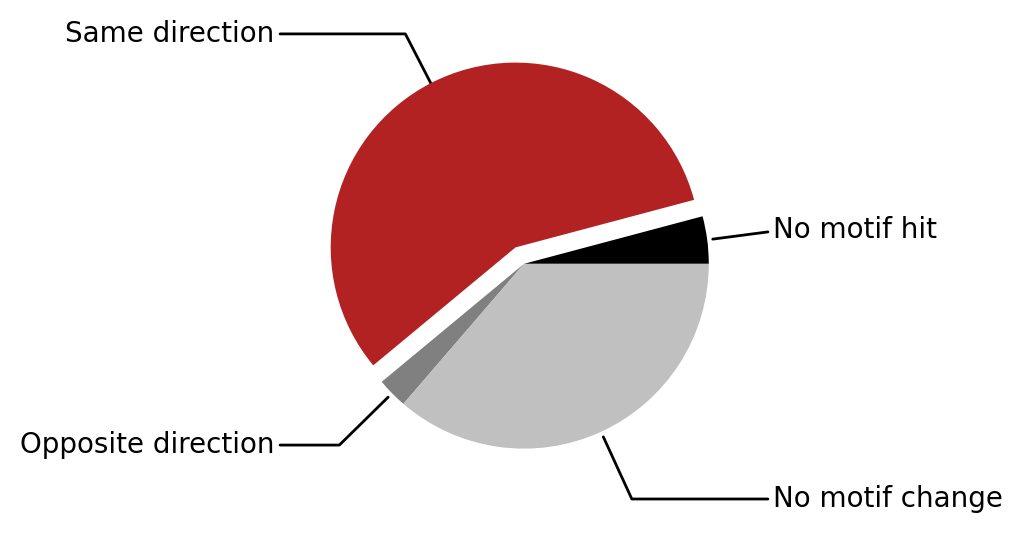

In [35]:

# Plot pie chart that shows how many of the affected sequences have motif hits, same direction as signal change, 
# and how many have motif hits, opposite direction as signal change, or no change at all
from matplotlib import category
import matplotlib.pyplot as plt
from DeepAllele.plotlib import piechart
import numpy as np
from torch import cat

significant_motif_hits = np.unique(np.concatenate([motif_hits[i] for i in significant_motifs]))


affected_with_sigmotif_hit = affected[np.isin(affected, significant_motif_hits)]
affected_categories = np.zeros(len(affected), dtype=int)
affecting_motifs = -np.ones(len(affected), dtype=int)

for i in affected_with_sigmotif_hit:
    affected_collection = []
    affected_motif_collection = []
    for j in significant_motifs:
        if i in motif_hits[j]:
            main_effect = np.sign(signals[i, 2]) * delta_motif_scores[j][np.where(motif_hits[j] == i)[0][0]]
            affected_collection.append(main_effect)
            affected_motif_collection.append(j)
    max_delta_effect = np.argmax(affected_collection)
    if affected_collection[max_delta_effect] > 0:
        affected_categories[affected == i] = 1
        affecting_motifs[affected == i] = affected_motif_collection[max_delta_effect]
    elif affected_collection[max_delta_effect] < 0:
        affected_categories[affected == i] = 2
        affecting_motifs[affected == i] = affected_motif_collection[max_delta_effect]
    elif affected_collection[max_delta_effect] == 0:
        affected_categories[affected == i] = 3

# Count the number of affected sequences in each category
all_categories = np.arange(4, dtype=int)
categories, category_counts = np.unique(affected_categories, return_counts=True)
category_percentages = np.zeros(4)
category_percentages[np.isin(all_categories, categories)] = category_counts
category_percentages = category_percentages / np.sum(category_percentages) * 100
print('Category percentages:', category_percentages)

# Create a pie chart
labels = ['No motif hit', 'Same direction', 'Opposite direction', 'No motif change']
# Create a pie chart
category_percentages += 0.01  # Add a small value to avoid zero percentages
figpie = piechart(category_percentages, labels = labels, colors = ['black', 'firebrick', 'grey', 'silver'], explode_size = None, explode_indices = 1, labels_on_side = True, explode_color = None)
figpie.savefig(os.path.join(path, Name + '_affected_motif_hits_piechart.png'), dpi=200, bbox_inches='tight')


### C. For same and opposite direction motifs (explainable changes), distribute the sequences to motifs in pie-chart

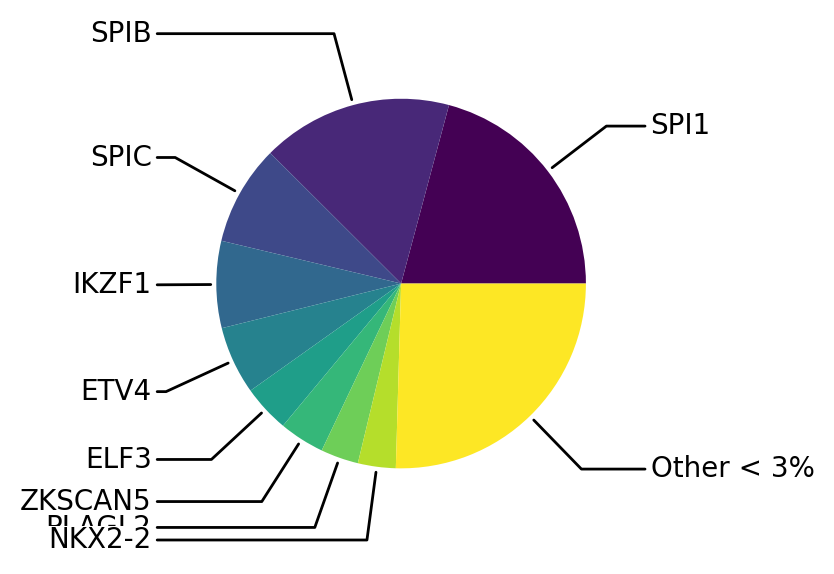

In [37]:
affecting_motifs = affecting_motifs[affecting_motifs != -1] # Remove unassigned entries
# Create a pie chart for the affected motifs
unique_motifs, motif_counts = np.unique(affecting_motifs, return_counts=True)
motif_percentages = motif_counts / np.sum(motif_counts) * 100
# summarize motif percentages below 3% into other category
other_motif_count = np.sum(motif_percentages[motif_percentages < 3])
unique_motifs = unique_motifs[motif_percentages >= 3]
motif_percentages = np.append(motif_percentages[motif_percentages >= 3], other_motif_count)
# sort the motifs by their percentage
sorted_indices = np.argsort(motif_percentages[:-1])[::-1]  # Sort in descending order
unique_motifs = unique_motifs[sorted_indices]
motif_percentages = np.append(motif_percentages[:-1][sorted_indices], motif_percentages[-1])  # Keep the 'Other < 3%' category at the end
# Create labels for the motifs
labels = [list(motifs.keys())[i] for i in unique_motifs] + ['Other < 3%']
# Create a pie chart
figmotif = piechart(motif_percentages, labels=labels, cmap = 'viridis', colors=None, explode_size=None, labels_on_side=True, explode_color=None)
figmotif.savefig(os.path.join(path, Name + '_affected_motif_hits_piechart_motifs.png'), dpi=200, bbox_inches='tight')
# NOTE: Instead one could also cluster the motifs more and summarize them

### D. Use significant motifs, and assign every sequence to the one with the highest effect abs effect

Sequences with significant motif hits: 8022 out of 8380


/tmp/ipykernel_15140/3784397049.py:71: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = ax.scatter(x, y, alpha=alpha, s=size, c=color, cmap=cmap, linewidth=lw)


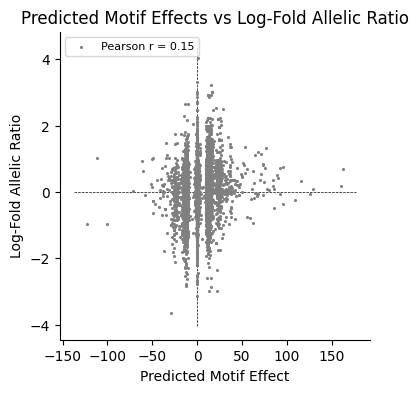

In [ ]:
import numpy as np
from DeepAllele.plotlib import scatter_plot

# Iterate over all sequences, find the motif hits of significant motifs for this sequence,
# determine the largest delta motif score corrected corrected by the general affect direction of the motif
predicted_motif_effects = np.zeros(len(seqlabels), dtype=np.float32)  # Initialize an array to store the predicted motif effects
have_significant_motif = np.unique(np.concatenate([motif_hits[i] for i in significant_motifs]))
print('Sequences with significant motif hits:', len(have_significant_motif), 'out of', len(seqlabels))
for s, sl in enumerate(seqlabels):
    if s in have_significant_motif:
        pred_effects = []
        for i in significant_motifs:
            if s in motif_hits[i]:
                # Get the delta motif score for this sequence
                delta_score = delta_motif_scores[i][np.where(motif_hits[i] == s)[0][0]]
                # Correct the delta score by the overall direction of the motif effect
                pred_effects.append(delta_score * np.sign(pearson_correlations[i]))
        predicted_motif_effects[s] = pred_effects[np.argmax(np.abs(pred_effects))] if pred_effects else 0
        
# Save the predicted motif effects to a text file with the sequence labels
np.savetxt(os.path.join(path, Name + '_predicted_motif_effects.txt'), 
           np.column_stack((seqlabels, predicted_motif_effects)), fmt='%s', delimiter='\t', header='Sequence Label\tPredicted Motif Effect')

# Plot scatter plot of delta motif effects vs log-fold allelic ratio
scatter_plot(predicted_motif_effects, signals[:, 2], motif=None, xlabel='Predicted Motif Effect', ylabel='Log-Fold Allelic Ratio',
             title='Predicted Motif Effects vs Log-Fold Allelic Ratio')#, save_path=os.path.join(path, Name + '_predicted_motif_effects_scatter.png'))


### E. Determine the sets of sequences that associate with the measured signal, the motif changes, or not

In [40]:
import numpy as np
import os
import matplotlib.pyplot as plt
from DeepAllele.plotlib import plot_heatmap

# Compute correlation between motifs
from DeepAllele.motif_analysis import torch_compute_similarity_motifs
# transform to list of motif arrays
motif_array = [motifs[mk].T for i, mk in enumerate(motifs) if i in significant_motifs]
motif_names = [mk for i, mk in enumerate(motifs) if i in significant_motifs]
# Compute the correlation matrix
correlation = torch_compute_similarity_motifs(motif_array, motif_array, metric = 'correlation',
                                              min_sim = 4, padding = 0.25, infocont = False, 
                                              reverse_complement = True, exact = True)

# Sort sequences with motif hits into four categories: 
# 1. Same delta motif direction as signal change
# 2. Opposite delta motif direction as signal change
# 3. No change in delta motif direction but signal change
# 4. No change in delta motif direction and no signal change
motif_hit_categories = [-np.ones(len(motif_hits[j])) for j in significant_motifs]
motif_hit_category_numbers = []
all_motif_hit_categories = np.arange(1,6, dtype=int)
signal_cut = 0.25
for k, j in enumerate(significant_motifs):
    for i in motif_hits[j]:
        delta_score = delta_motif_scores[j][np.where(motif_hits[j] == i)[0][0]]
        if np.abs(signals[i, 2]) >= signal_cut:
            # Check if the delta motif score is positive or negative
            if delta_score * np.sign(signals[i, 2]) > 0:
                motif_hit_categories[k][motif_hits[j] == i] = 1
            elif delta_score * np.sign(signals[i, 2]) < 0:
                motif_hit_categories[k][motif_hits[j] == i] = 2
            elif delta_score == 0:
                motif_hit_categories[k][motif_hits[j] == i] = 3
        else:
            # No signal change, check if the delta motif score is zero
            if delta_score == 0:
                motif_hit_categories[k][motif_hits[j] == i] = 4
            else:
                motif_hit_categories[k][motif_hits[j] == i] = 5  # No motif hit
    # Count the number of sequences in each category
    categories, category_counts = np.unique(motif_hit_categories[k], return_counts=True)
    category_percentages = np.zeros(5)
    category_percentages[np.isin(all_motif_hit_categories, categories)] = category_counts
    motif_hit_category_numbers.append(category_percentages)
    print(f'Motif {j}: Category percentages:', category_percentages)
    
outname = os.path.join(path, Name +'number_seqcategories_motif_tree')
# Plot the negative log10 p-values for each significant motif in motif tree
plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = correlation, # matrix that determines order of data points on y-axis
                 sorty = 'average', # same as above but for y axis
                 pwms = motif_array, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = True,
                 yticklabels = np.array(motif_names),
                 dpi = 200,
                 figname = outname,
                 fmt = '.jpg',
                 cellsize = 0.4,
                 cellratio = 1.,
                 noheatmap = True,
                 row_distributions = np.array(motif_hit_category_numbers).T,  # Use negative log10 p-values for row distributions
                 row_distribution_kwargs = {'barplot' : True, 'ylabel': 'Number sequences', 'split' : 5,
                                            'facecolor': ['firebrick', 'indigo', 'lightblue', 'black', 'grey'],
                                            'legend_above' : True,
                                             'legend_labels': ['Same direction', 'Opposite direction', 'No change in motif', 'No change in both', 'No change in signal']})

outname = os.path.join(path, Name +'percentage_seqcategories_motif_tree')
# Plot the negative log10 p-values for each significant motif in motif tree
plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = correlation, # matrix that determines order of data points on y-axis
                 sorty = 'average', # same as above but for y axis
                 pwms = motif_array, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = True,
                 yticklabels = np.array(motif_names),
                 dpi = 200,
                 figname = outname,
                 fmt = '.jpg',
                 cellsize = 0.4,
                 cellratio = 1.,
                 noheatmap = True,
                 row_distributions = np.array(motif_hit_category_numbers).T/np.sum(motif_hit_category_numbers, axis = 1)[None,]*100,  # Use negative log10 p-values for row distributions
                 row_distribution_kwargs = {'barplot' : True, 'ylabel': 'Percent sequences', 'split' : 5,
                                            'facecolor': ['firebrick', 'indigo', 'lightblue', 'black', 'grey'],
                                            'legend_above' : True,
                                             'legend_labels': ['Same direction', 'Opposite direction', 'No change in motif', 'No change in both', 'No change in signal']})


Motif 125: Category percentages: [220. 153. 602. 479. 182.]
Motif 126: Category percentages: [324. 197. 984. 725. 219.]
Motif 131: Category percentages: [ 340.  174. 1109.  762.  237.]
Motif 178: Category percentages: [ 571.  349. 1100.  807.  462.]
Motif 251: Category percentages: [167. 116. 498. 391. 161.]
Motif 321: Category percentages: [ 35.  14. 117.  70.  34.]
Motif 322: Category percentages: [ 36.  13. 114.  69.  33.]
Motif 365: Category percentages: [42. 28. 85. 62. 49.]
Motif 422: Category percentages: [108.  64. 374. 224.  85.]
Motif 426: Category percentages: [102.  57. 348. 216.  84.]
Motif 429: Category percentages: [112.  63. 339. 216.  93.]
Motif 442: Category percentages: [ 46.  44. 154.  82.  49.]
Motif 468: Category percentages: [168. 113. 412. 375. 147.]
Motif 469: Category percentages: [119.  65. 425. 310. 109.]
Motif 489: Category percentages: [ 564.  363. 1455. 1026.  486.]
Motif 526: Category percentages: [ 49.  27. 121.  54.  53.]
Motif 652: Category percentage

(None,
 [15,
  17,
  4,
  13,
  2,
  24,
  1,
  0,
  12,
  3,
  27,
  28,
  14,
  23,
  20,
  22,
  25,
  19,
  21,
  18,
  5,
  6,
  7,
  16,
  11,
  26,
  9,
  8,
  10])